In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import utils.genprodUtils as gen

In [4]:
from utils.genprodUtils import two_body_decay, hadronization
from utils.genprodUtils.generators.x_hh_4b import swap_objects, Generator, cluster_jets, gen_match_jets

4


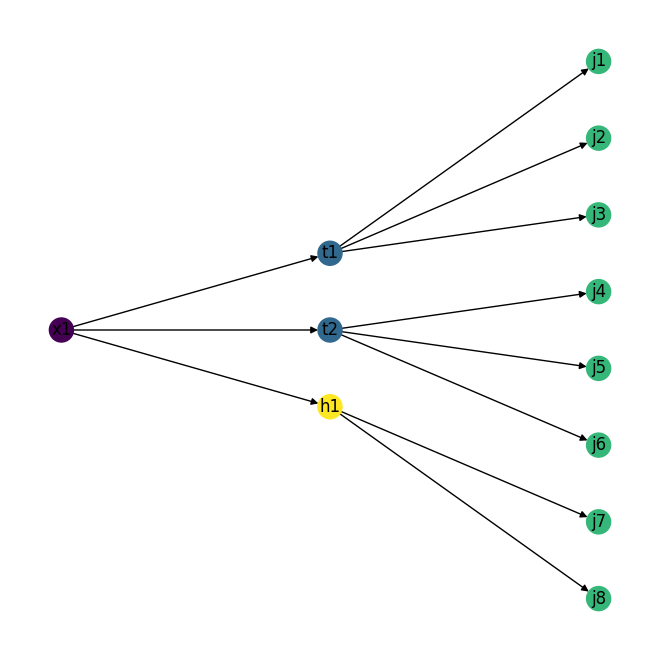

In [5]:
from utils.FeynNet.Feynman import Feynman

t_wb_3j = lambda : Feynman('t').decays(
                        Feynman('w').decays('j','j'),
                        Feynman('b').decays('j'),
                    )
t_3j = lambda : Feynman('t').decays('j','j','j')
h_bb_2j = lambda : Feynman('h').decays(
        Feynman('b').decays('j'),
        Feynman('b').decays('j'),
    )
h_2j = lambda : Feynman('h').decays('j','j')


diagram = Feynman('x').decays(
    t_3j(), t_3j(), h_2j()
)

diagram.draw_diagram()

perms = diagram.get_finalstate_permutations(j=8)

In [6]:
perms['j'].shape

(280, 8)

In [6]:
f_sig = '/uscms_data/d3/ekoenig/8BAnalysis/studies/eightbStudies/scripts/ntuples/ttH/x_tth_8j.root'
sig = Tree(f_sig, treename='Events', normalization=None, sample='ttH', color='red', is_signal=True)

f_qcd = '/uscms_data/d3/ekoenig/8BAnalysis/studies/eightbStudies/scripts/ntuples/ttH/qcd.root'
qcd = Tree(f_qcd, treename='Events', normalization=None, sample='qcd', color='lightblue', is_signal=False)

100%|██████████| 1/1 [00:00<00:00, 41.01it/s]


In [7]:
presel_jets = CollectionFilter('jet', filter=lambda tree : (tree.jet_pt > 20) & (abs(tree.jet_eta) < 2.5))
sig = presel_jets(sig)
qcd = presel_jets(qcd)

100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


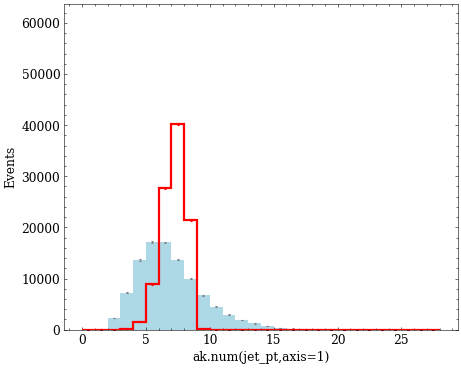

In [8]:
study.quick(
    [sig, qcd],
    varlist=['ak.num(jet_pt,axis=1)'],
    lumi=None,
)

In [9]:
at_least_8_jets = EventFilter('at_least_8_jets', filter=lambda tree : ak.num(tree.jet_pt,axis=1) >= 8, verbose=True)
sig = at_least_8_jets(sig)
qcd = at_least_8_jets(qcd)

ttH at_least_8_jets eff: 2.15e-01
qcd at_least_8_jets eff: 2.88e-01


100%|██████████| 32/32 [00:02<00:00, 12.13it/s]


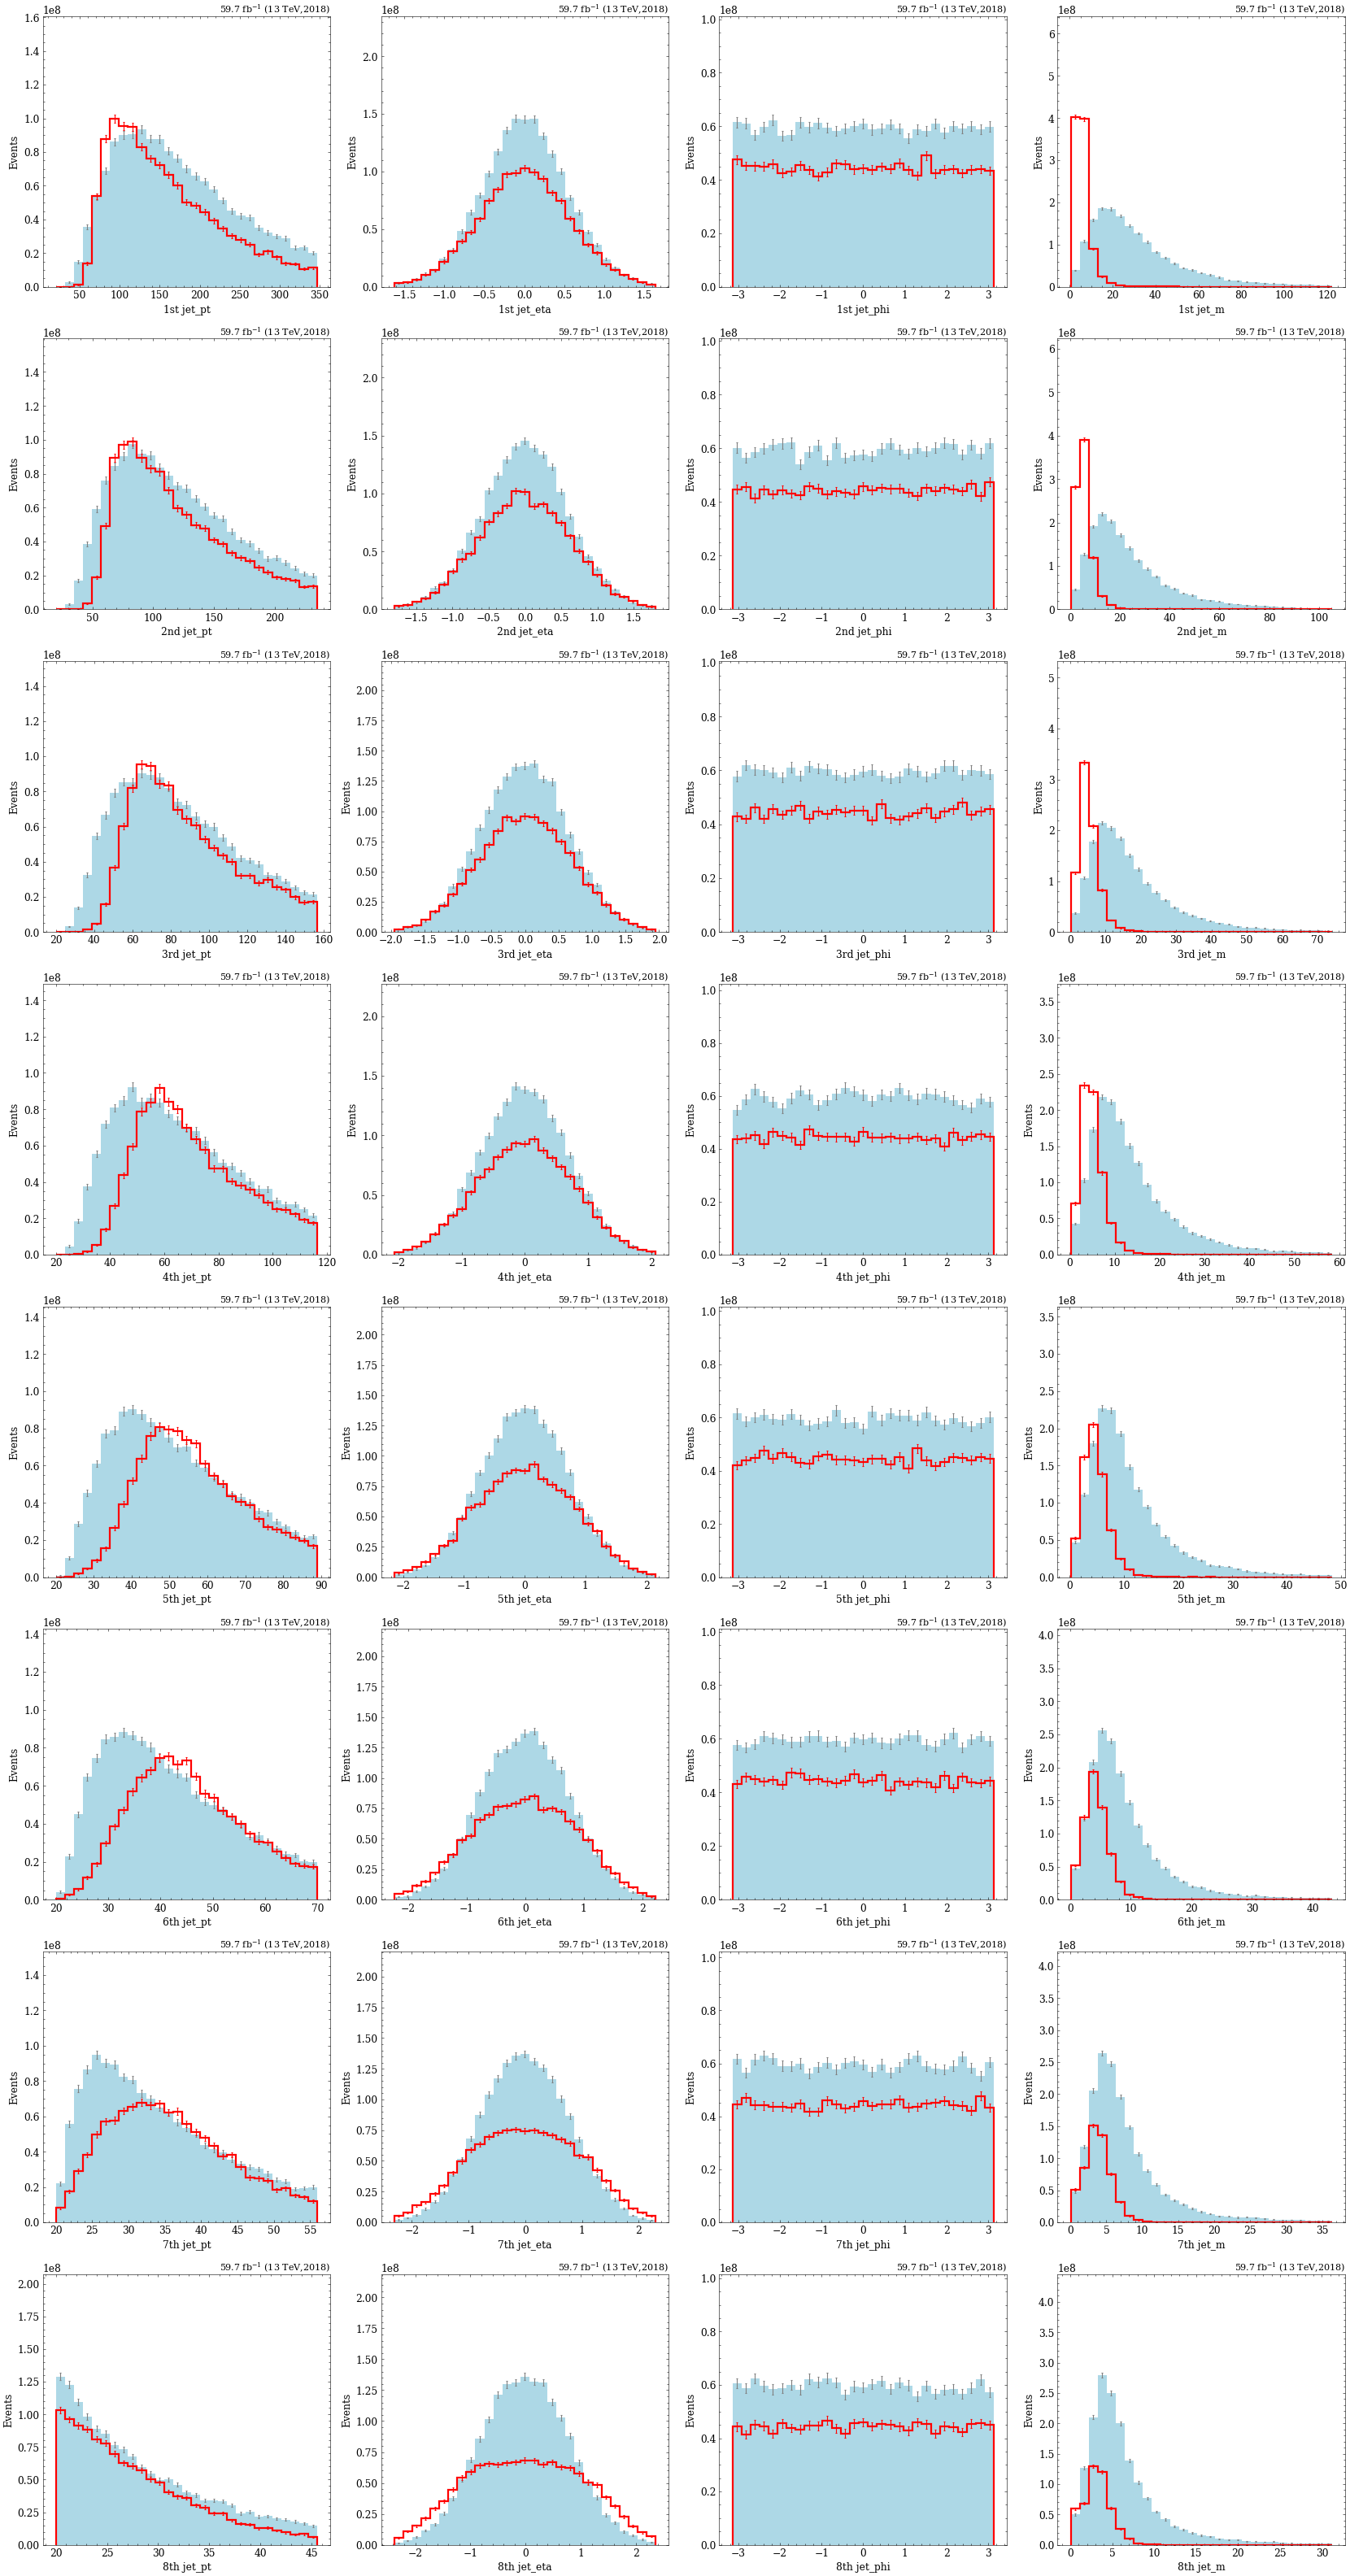

In [10]:
study.quick(
    [sig, qcd],
    varlist=[f'jet_{var}[:,{i}]' for i in range(8) for var in ['pt','eta','phi','m'] ],
    dim=(8,4),
)

100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


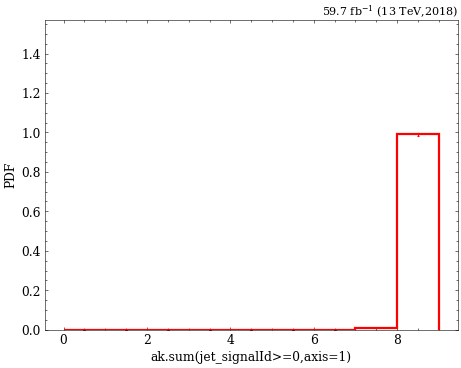

In [11]:
study.quick(
    [sig],
    varlist=['ak.sum(jet_signalId>=0,axis=1)'],
    efficiency=True,
)

In [12]:
jet_p4 = build_p4(sig, 'jet', use_regressed=False, extra=['signalId'])

In [35]:
def reconstruct(jet_p4, assignment):
    j1 = ak.from_regular(assignment[:,[0, 3, 6]])
    j2 = ak.from_regular(assignment[:,[1, 4, 7]])
    j3 = ak.from_regular(assignment[:,[2, 5]])
    wh_p4 = jet_p4[j1] + jet_p4[j2]

    w_p4 = wh_p4[:,:2]
    h_p4 = wh_p4[:, 2]
    t_p4 = w_p4 + jet_p4[j3]

    return dict(
        **{
            f'T{i+1}_{var}' : getattr(t_p4[:,i], var)
            for i in range(2)
            for var in ('pt','eta','phi','m')
        },
        **{
            f'T{i+1}_W_{var}' : getattr(w_p4[:,i], var)
            for i in range(2)
            for var in ('pt','eta','phi','m')
        },
        **{
            f'H_{var}' : getattr(h_p4, var)
            for var in ('pt','eta','phi','m')
        }
    )

In [45]:
def load_true_assignment(tree):
    jet_p4 = build_p4(tree, 'jet', use_regressed=False, extra=['signalId'])
    assignment = ak.argsort(jet_p4.signalId, axis=1)[:,:8]

    tree.extend( **reconstruct(jet_p4, assignment) )
    
load_true_assignment(sig)

6it [00:00, 41.48it/s]                       


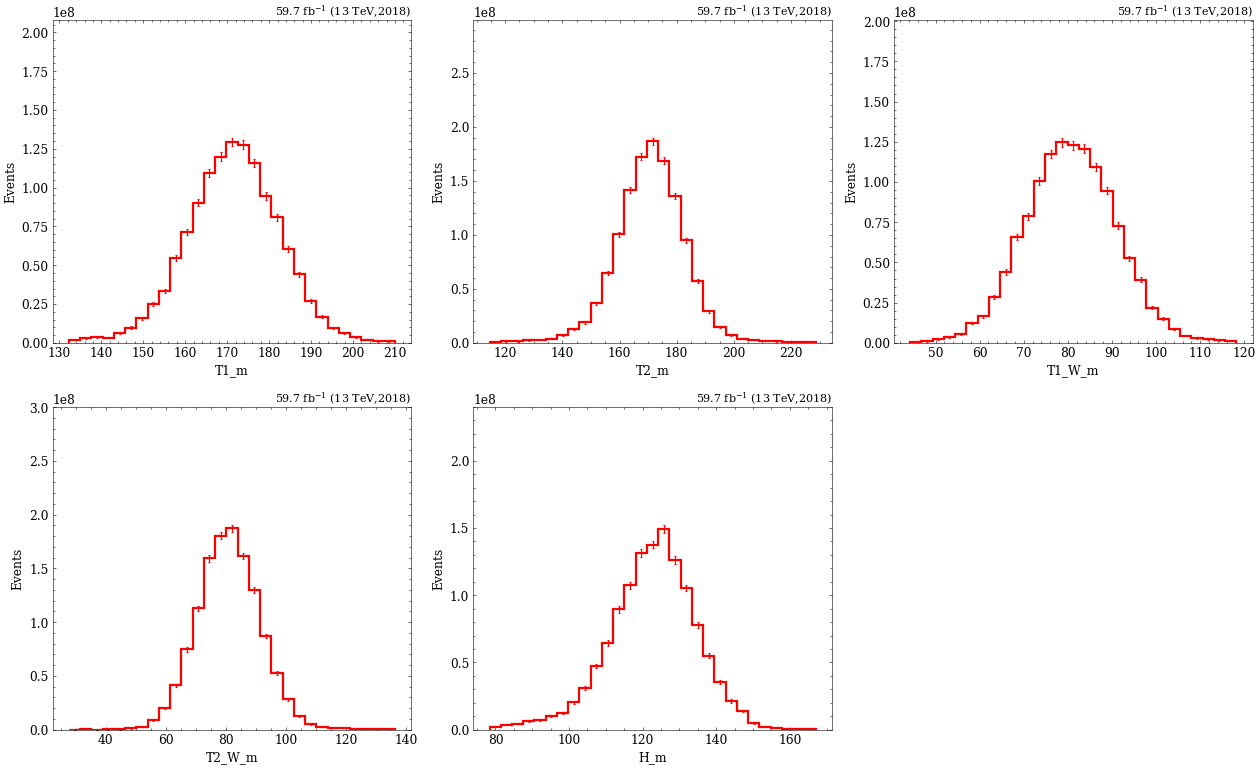

In [47]:
study.quick(
    [sig],
    varlist=['T1_m','T2_m','T1_W_m','T2_W_m','H_m'],
)